In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
# READ THE FILE INTO A DATAFRAME
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")

In [4]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,...,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,...,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,...,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,...,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,...,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,...,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [5]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)

In [6]:
df.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].str.replace(' days', '')
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].astype(int)
num_features = df.drop(['ID','USER_ID','PRODUCT_ID','DATE','REVIEW_TEXT','LABEL'],axis=1)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['REVIEW_TEXT'] , df['LABEL'], test_size=0.25, random_state=42)

print('X_train.shape:', X_train.shape)

print('X_test.shape', X_test.shape)

X_train.shape: (14955,)
X_test.shape (4985,)


In [8]:
print(X_train)

5864     sunday night friends line consistently door mo...
17712    place amazing kitchen sink salad mac n cheese ...
7463     large portions cheap pricing legitly delicious...
4294     extra virgin little pricey worth every penny e...
7975     italian citizen readily admit italian snob gro...
                               ...                        
11284    love love love decor great nice days windows c...
11964    8 pm wednesday long wait place packedgotta goo...
5390     warning spot gets packed really good food drin...
860      always end brunch least twice month nearby dom...
15795    came bf first started dating really gross prob...
Name: REVIEW_TEXT, Length: 14955, dtype: object


In [9]:
# Load pre-trained GloVe embeddings
# Replace 'glove.6B.100d.txt' with the path to your GloVe embeddings file
glove_model = KeyedVectors.load_word2vec_format('../../Fake review detection dataset/glove.6B.200d.txt',binary=False, no_header=True)

In [10]:
# Function to convert reviews to GloVe embeddings
def glove_average(glove_model, words):
    all_words, mean = set(), []
    
    for word in words:
        if word in glove_model:
            mean.append(glove_model[word])
            all_words.add(word)

    if not mean:
        return np.zeros(glove_model.vector_size,)

    mean = np.array(mean).mean(axis=0)
    return mean

def glove_average_list(glove_model, text_list):
    return np.vstack([glove_average(glove_model, post) for post in text_list])

# Transform text to GloVe embeddings
X_train_glove_average = glove_average_list(glove_model, X_train)
X_test_glove_average = glove_average_list(glove_model, X_test)

In [11]:
print(X_train_glove_average.shape)
print(y_train.shape)
print(y_test.shape)

(14955, 200)
(14955,)
(4985,)


In [12]:
# # Apply ADASYN for balancing classes
# adasyn = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_glove_average, y_train)

In [14]:
print(X_train_glove_average.shape)
print(X_test.shape)
print(X_train_glove_average.shape)
print(y_test.shape)

(14955, 200)
(4985,)
(14955, 200)
(4985,)


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
# from sklearn.impute import SimpleImputer
# from imblearn.pipeline import Pipeline as ImbPipeline
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split
# from sklearn.base import TransformerMixin, BaseEstimator
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import SVC
# import pandas as pd

# class TextPreprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self, max_features=5000, ngram_range=(1, 3)):
#         self.max_features = max_features
#         self.ngram_range = ngram_range

#     def fit(self, X, y=None):
#         self.vectorizer = TfidfVectorizer(max_features=self.max_features, ngram_range=self.ngram_range)
#         self.vectorizer.fit(X)
#         return self

#     def transform(self, X):
#         return self.vectorizer.transform(X)

# # Create the full pipeline with preprocessing and SVC
# pipeline = ImbPipeline([
#     ('preprocessor', TextPreprocessor()),
#     ('adasyn', ADASYN()),
#     ('classifier', SVC(kernel='linear', probability=True))
# ])

In [20]:
# Oversampling with adasyn
adasyn = ADASYN(random_state=42)   #smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_glove_average, y_train )

In [21]:
# Create a pipeline
model = SVC(kernel='linear', probability=True)

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear', probability=True)

In [23]:
# Make predictions
y_pred = model.predict(X_test_glove_average)

In [24]:
print(y_test.shape)
print(y_pred.shape)

(4985,)
(4985,)


In [25]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6439317953861585
Confusion Matrix:
 [[ 237  264]
 [1511 2973]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.14      0.47      0.21       501
           1       0.92      0.66      0.77      4484

    accuracy                           0.64      4985
   macro avg       0.53      0.57      0.49      4985
weighted avg       0.84      0.64      0.71      4985



In [26]:
# Predict probabilities for test data
y_pred_proba = model.predict_proba(X_test_glove_average)[:, 1]

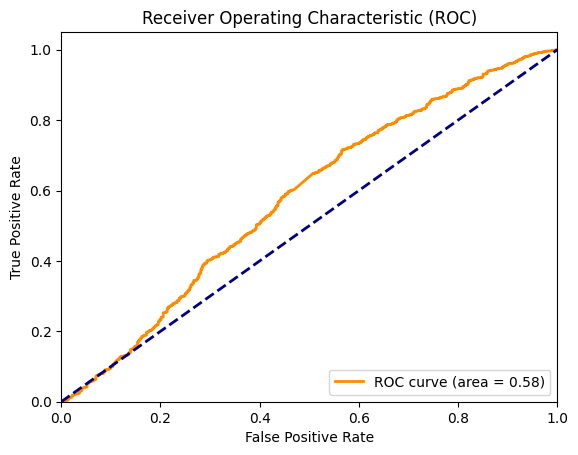

In [27]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [28]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print sensitivity and specificity
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.6630240856378233
Specificity (True Negative Rate): 0.47305389221556887
